In [1]:
import sys 
sys.path.append("../")
from QAOAUtils import * 

In [2]:
n = 8
A= rand_adj(n)
A

array([[0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 0, 1, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1],
       [1, 0, 1, 1, 1, 1, 0, 1],
       [0, 1, 0, 0, 1, 1, 1, 0]], dtype=int32)

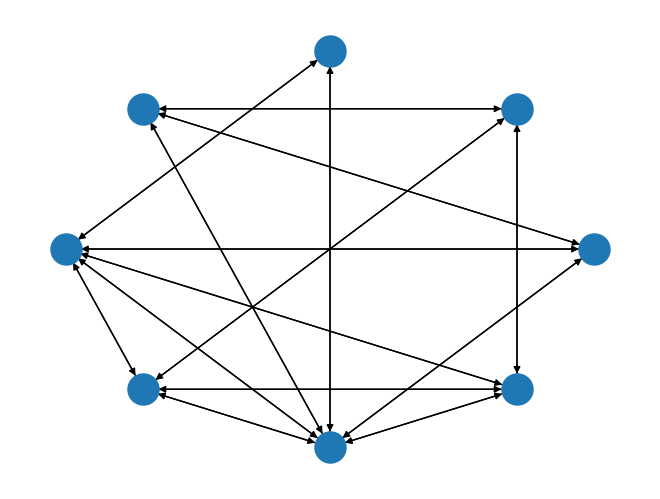

In [3]:
import networkx as nx
G = nx.DiGraph(A)
nx.draw(G, nx.circular_layout(G), node_size=500)


### Single Layer Behavior

In [4]:
Y = GW(A)  ###calculate the full GW embedding
_,GW2_angles,_ = GW2(A,GW_Y=Y,reps=500) ###project to 2d angles using precalculated GW embedding 
_,GW3_angles,_ = GW3(A,GW_Y=Y,reps=500) ###project to 2d angles using precalculated GW embedding 

In [5]:
###Get circuit information for each warmstart. Circuit information consists of the initial state + the mixer operators for each qubit
GW2_circ_data = Q2_data(GW2_angles,rotation = 0)
GW3_circ_data = Q3_data(GW3_angles,rotation = 0)

precomp  = pre_compute(A) ###compute the Hamiltonian information for the cost layers (shared for all circuits)

In [6]:
default_data = np.zeros((100,100))
for x,i in enumerate(np.linspace(0,2*np.pi,100)):
    for y,j in enumerate(np.linspace(0,2*np.pi,100)):
        default_data[x,y] = expval(precomp,QAOA_eval(precomp,[i,j],mixer_ops=None,init=None))

In [7]:
GW2_data = np.zeros((100,100))
for x,i in enumerate(np.linspace(0,2*np.pi,100)):
    for y,j in enumerate(np.linspace(0,2*np.pi,100)):
        GW2_data[x,y] = expval(precomp,QAOA_eval(precomp,[i,j],mixer_ops=GW2_circ_data[1],init=GW2_circ_data[0]))

In [8]:
GW3_data = np.zeros((100,100))
for x,i in enumerate(np.linspace(0,2*np.pi,100)):
    for y,j in enumerate(np.linspace(0,2*np.pi,100)):
        GW3_data[x,y] = expval(precomp,QAOA_eval(precomp,[i,j],mixer_ops=GW3_circ_data[1],init=GW3_circ_data[0]))

In [9]:
[np.max(x) for x in [default_data, GW2_data, GW3_data]]

[np.float64(1.7819413545670728),
 np.float64(3.966395714163359),
 np.float64(3.993437989105047)]

### Plot of loss and gradient landscapes

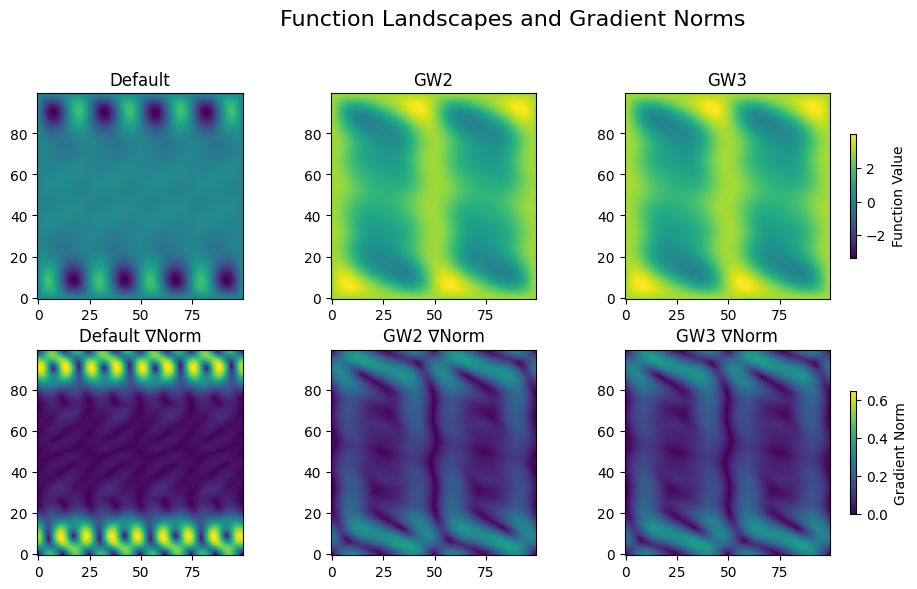

In [10]:
default_grad_norm = np.sqrt(np.gradient(default_data)[0]**2 + np.gradient(default_data)[1]**2)
GW2_grad_norm = np.sqrt(np.gradient(GW2_data)[0]**2 + np.gradient(GW2_data)[1]**2)
GW3_grad_norm = np.sqrt(np.gradient(GW3_data)[0]**2 + np.gradient(GW3_data)[1]**2)

# Get vmin/vmax for consistent color scales
vmin = np.min([default_data, GW2_data, GW3_data])
vmax = np.max([default_data, GW2_data, GW3_data])
vmin_grad = np.min([default_grad_norm, GW2_grad_norm, GW3_grad_norm])
vmax_grad = np.max([default_grad_norm, GW2_grad_norm, GW3_grad_norm])

# Create subplots with constrained layout and reduced spacing
fig, axes = plt.subplots(2, 3, figsize=(14, 6), constrained_layout=False)
fig.subplots_adjust(wspace=0.15, hspace=0.25, right=0.85)  # Space between plots and reserve room for colorbars

# First row: function landscapes
im0 = axes[0, 0].imshow(default_data.T, vmin=vmin, vmax=vmax,origin='lower')
axes[0, 0].set_title("Default")

im1 = axes[0, 1].imshow(GW2_data.T, vmin=vmin, vmax=vmax,origin='lower')
axes[0, 1].set_title("GW2")

im2 = axes[0, 2].imshow(GW3_data.T, vmin=vmin, vmax=vmax,origin='lower')
axes[0, 2].set_title("GW3")

# Second row: gradient norms
im3 = axes[1, 0].imshow(default_grad_norm.T, vmin=vmin_grad, vmax=vmax_grad, cmap='viridis',origin='lower')
axes[1, 0].set_title("Default ∇Norm")

im4 = axes[1, 1].imshow(GW2_grad_norm.T, vmin=vmin_grad, vmax=vmax_grad, cmap='viridis',origin='lower')
axes[1, 1].set_title("GW2 ∇Norm")

im5 = axes[1, 2].imshow(GW3_grad_norm.T, vmin=vmin_grad, vmax=vmax_grad, cmap='viridis',origin='lower')
axes[1, 2].set_title("GW3 ∇Norm")

# Add vertical colorbars on the right side
cbar1 = fig.colorbar(im0, ax=axes[0, :], location='right', shrink=0.6, pad=0.02)
cbar1.set_label('Function Value')

cbar2 = fig.colorbar(im3, ax=axes[1, :], location='right', shrink=0.6, pad=0.02)
cbar2.set_label('Gradient Norm')

# Suptitle and layout finalization
plt.suptitle("Function Landscapes and Gradient Norms", fontsize=16, y=1.02)
plt.show()

In [11]:
def grad_ascent(x_init,grad_func,alpha,iters):
    list = [np.array(x_init)]
    for i in range(iters):
        grad = grad_func(list[-1])
        list.append( list[-1] + alpha * np.array(grad))
    return list

In [12]:
default_grad = lambda x: QAOA_gradient_eval(precomp,x,mixer_ops=None,init=None)
default_cost = lambda x: expval(precomp,QAOA_eval(precomp,x,mixer_ops=None,init=None))

default_data_hist = [] 
default_cost_hist = []
for i in tqdm(range(100)):
    x_init = np.random.random(2) *np.pi + np.pi/2
    data = grad_ascent(x_init,default_grad,1e-3,500)
    cost_data = [default_cost(x) for x in data]
    
    default_data_hist.append(data)
    default_cost_hist.append(cost_data)
    

GW2_grad = lambda x: QAOA_gradient_eval(precomp,x,mixer_ops=GW2_circ_data[1],init=GW2_circ_data[0])
GW2_cost = lambda x: expval(precomp,QAOA_eval(precomp,x,mixer_ops=GW2_circ_data[1],init=GW2_circ_data[0]))

GW2_data_hist = [] 
GW2_cost_hist = []
for i in tqdm(range(100)):
    x_init = np.random.random(2) *np.pi + np.pi/2
    data = grad_ascent(x_init,GW2_grad,1e-3,500)
    cost_data = [GW2_cost(x) for x in data]
    
    GW2_data_hist.append(data)
    GW2_cost_hist.append(cost_data)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Evolution of randomly selected parameters in $[\pi/2,3\pi/2]^2$ with no warmstart

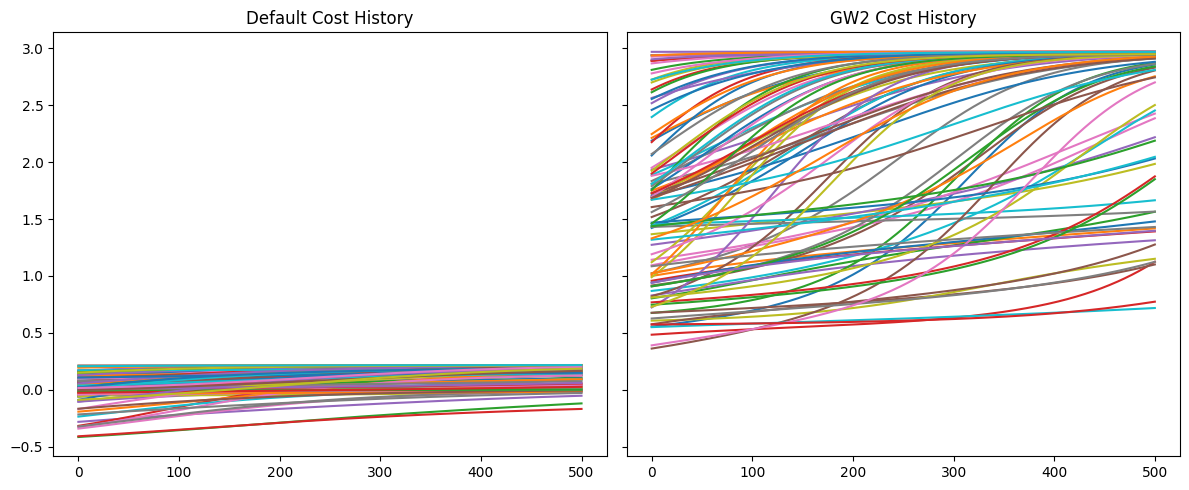

In [13]:

# Create a figure and two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(12, 5),sharey=True)  # Adjust figsize as needed

# First subplot: default_cost_hist
axs[0].plot(np.array(default_cost_hist).T)
axs[0].set_title('Default Cost History')

# Second subplot: GW2_cost_hist
axs[1].plot(np.array(GW2_cost_hist).T)
axs[1].set_title('GW2 Cost History')

# Display the plots
plt.tight_layout()
plt.show()

In [14]:
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, axs = plt.subplots(1, 2, figsize=(12, 5),sharey=True)  # Adjust figsize as needed

def animate(t):
    
    axs[0].cla()
    axs[1].cla()
    
    axs[0].scatter([d[10 * t ][0] for d in  default_data_hist],[d[10 * t ][1] for d  in default_data_hist],color='red')
    axs[0].imshow(default_data.T,origin='lower',extent=[0,2*np.pi,0,2*np.pi], vmin=vmin, vmax=vmax)
    
    axs[1].scatter([d[10 * t ][0] for d in  GW2_data_hist],[d[10 * t ][1] for d  in GW2_data_hist],color='red')
    axs[1].imshow(GW2_data.T,origin='lower',extent=[0,2*np.pi,0,2*np.pi], vmin=vmin, vmax=vmax)
    
    axs[0].set_title("Default")
    axs[1].set_title("GW2")

matplotlib.animation.FuncAnimation(fig, animate, frames=50)